
# R : SDM : Montane woodcreper
-----------------------

BIO401-01/598-02 
 
Apr. 7 2021


## Preparation

Start R in the bash terminal and run the following lines to install the libraries. 
 
    install.packages("rworldmap")
    install.packages("maptools")
    install.packages("rgeos")
    install.packages("reshape")

In [7]:
library(ggplot2)
# library(rworldmap)
library(rgdal)
library(raster)
# library(maptools)
library(rgeos)
library(reshape)
library(rasterVis)
library(dismo)
library(InformationValue)
library(mgcv)

Loading required package: terra
terra version 1.1.4

NOTE: using GDAL version 2.3.3 
For full functionality you need at least version 3.0.4


Attaching package: ‘terra’

The following object is masked from ‘package:reshape’:

    expand

The following object is masked from ‘package:rgdal’:

    project

Loading required package: lattice
Loading required package: latticeExtra

Attaching package: ‘latticeExtra’

The following object is masked from ‘package:ggplot2’:

    layer


Attaching package: ‘dismo’

The following object is masked from ‘package:terra’:

    voronoi

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:terra’:

    collapse

The following object is masked from ‘package:raster’:

    getData

This is mgcv 1.8-34. For overview type 'help("mgcv-package")'.


In [8]:
set.seed(30)

## Data Exploration

We will use Montane woodcreper (Lepidocolaptes lacrymiger) as example species. 

This species has a large range, occurring from the coastal cordillera of Venezuela along the Andes south to south-east Peru and central Bolivia.

<img src='./images/Montane_Woodcreeper.jpg' width="400">

### Read in points data 

In [9]:
birdrange <- readOGR("./geodata/shp", "cartodb-query")

OGR data source with driver: ESRI Shapefile 
Source: "/media/sf_LVM_shared/my_SE_data/exercise/geodata/shp", layer: "cartodb-query"
with 2 features
It has 7 fields


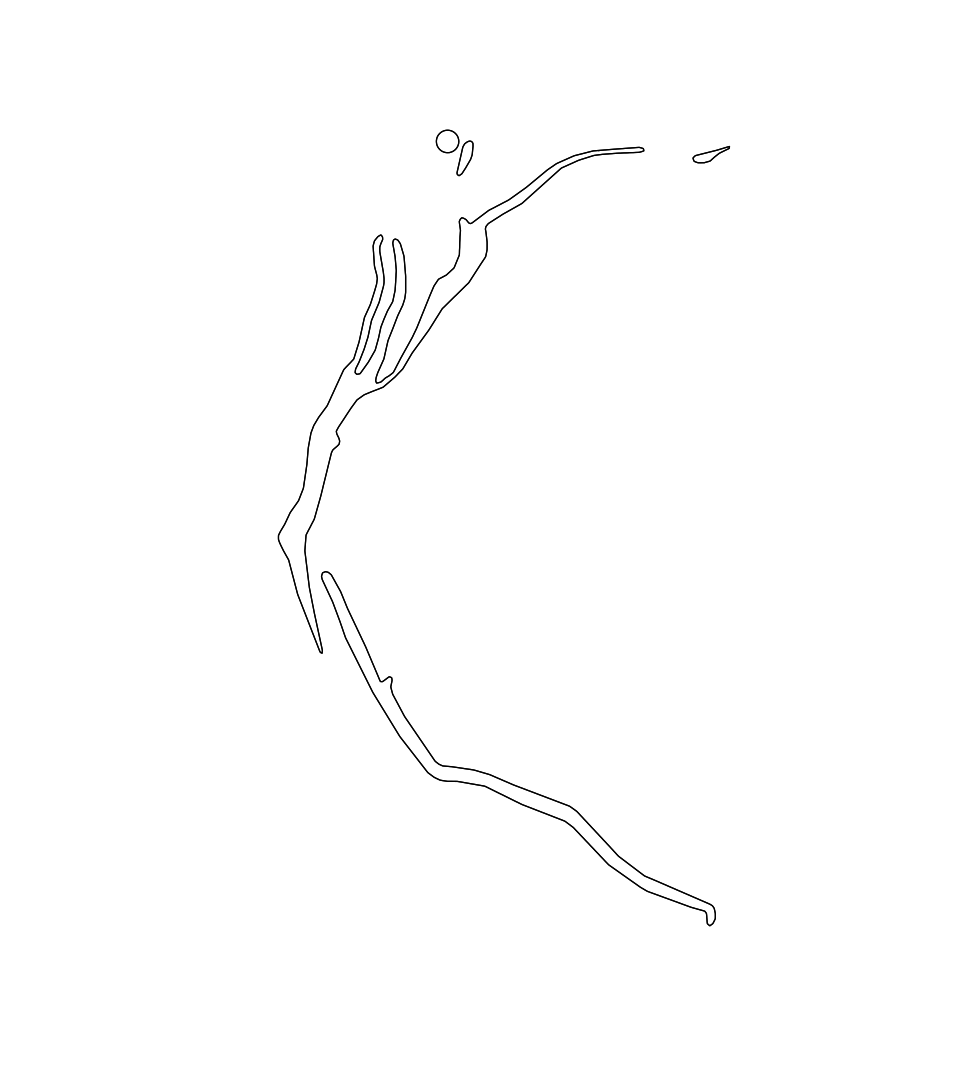

In [10]:
options(repr.plot.width=8, repr.plot.height=9)
plot(birdrange)

In [11]:
 points <- read.csv("./geodata/shp/Lepidocolaptes_lacrymiger_allpoints.csv")
 head(points)

lon,lat,scientific_name
-76.18925,3.98125,Lepidocolaptes_lacrymiger
-76.18406,3.93442,Lepidocolaptes_lacrymiger
-74.30256,4.60675,Lepidocolaptes_lacrymiger
-74.30256,4.60675,Lepidocolaptes_lacrymiger
-76.10394,4.74631,Lepidocolaptes_lacrymiger
-76.13861,4.74536,Lepidocolaptes_lacrymiger


### Read the environmental data layers

In [85]:
rCld   <- raster("./geodata/cloud/SA_meanannual_crop_msk.tif")
rCld   =  setMinMax(rCld)
rCldIA <- raster("./geodata/cloud/SA_intra_crop_msk.tif")
rCldIA =  setMinMax(rCldIA)
rElv   <- raster("./geodata/dem/SA_elevation_mn_GMTED2010_mn_crop_msk.tif")
rElv   =  setMinMax(rElv)
rVeg   <- raster("./geodata/vegetation/SA_tree_mn_percentage_GFC2013_crop_msk.tif")
rVeg   =  setMinMax(rVeg)
rElv

class      : RasterLayer 
dimensions : 4200, 2760, 11592000  (nrow, ncol, ncell)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -59, -21, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /media/sf_LVM_shared/my_SE_data/exercise/geodata/dem/SA_elevation_mn_GMTED2010_mn_crop_msk.tif 
names      : SA_elevation_mn_GMTED2010_mn_crop_msk 
values     : -72, 6460  (min, max)


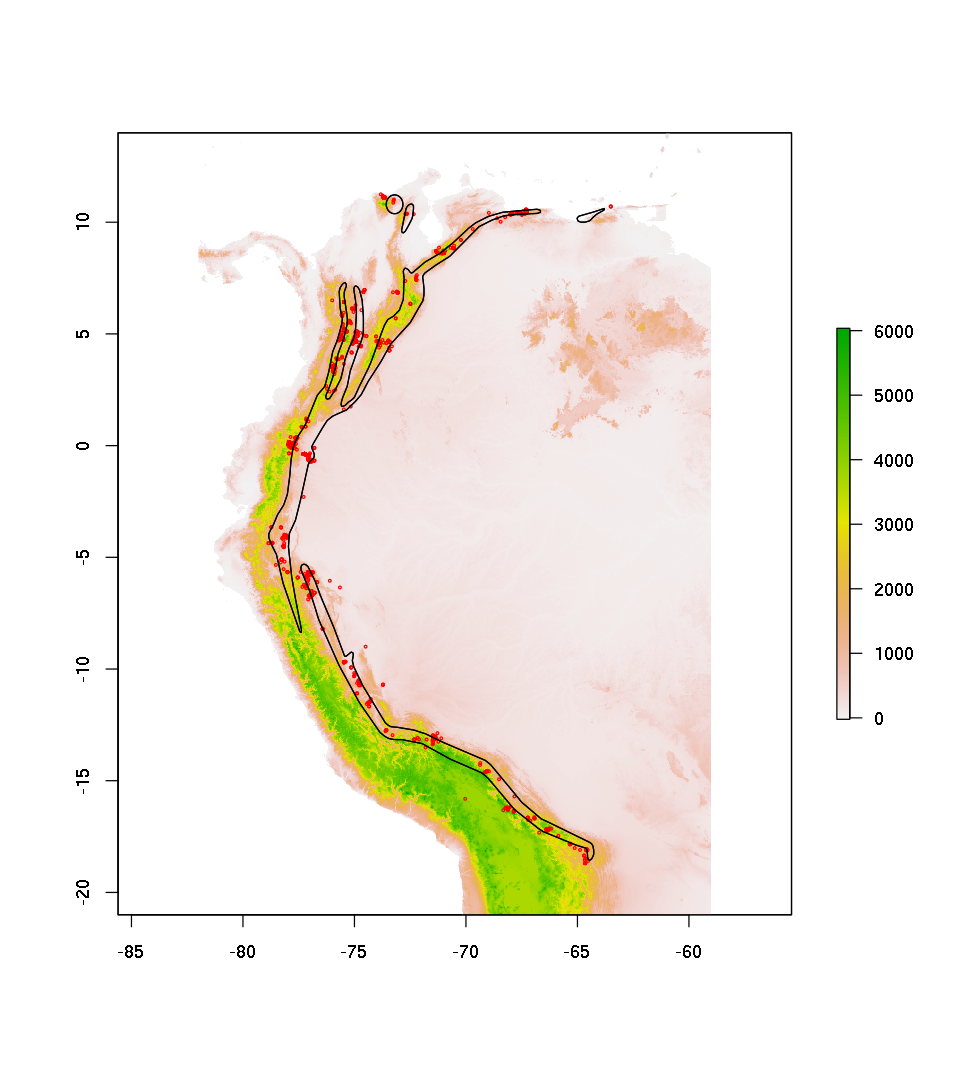

In [14]:
# mapSA <- getMap(resolution = "low")
# plot(mapSA, xlim = c(-80, -60), ylim = c(-30, 15), asp = 1)
plot(rElv)
points(points$lon, points$lat, col = "red", cex = .3)
plot(birdrange,add=TRUE)

In [15]:
# indicate that these data are presences
presence <- matrix(1,nrow(points),1)
points <- cbind(points,presence)

In [16]:
head(points)

lon,lat,scientific_name,presence
-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


In [17]:
# building spatial dataframe
points <- SpatialPointsDataFrame(points[,c(1,2)], points)

In [18]:
class(points)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

In [19]:
# assign projection
projection(points) <- "+proj=longlat +datum=WGS84" 

In [20]:
head(points)

lon,lat,scientific_name,presence
-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


Loading eBird sampling dataset, in order to obtain “absence” data

In [61]:
# link to global sampling raster
system("gdal_translate -projwin -82 14 -59 -21 -co COMPRESS=DEFLATE -co ZLEVEL=9 ./geodata/SDM/eBirdSampling_filtered.tif ./geodata/SDM/eBirdSampling_filtered_crop.tif ")
gsampling <- raster("./geodata/SDM/eBirdSampling_filtered_crop.tif")

In [63]:
# assign projection
projection(gsampling)="+proj=longlat +datum=WGS84"
gsampling

class      : RasterLayer 
dimensions : 4200, 2760, 11592000  (nrow, ncol, ncell)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -59, -20.99999, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0 
source     : /media/sf_LVM_shared/my_SE_data/exercise/geodata/SDM/eBirdSampling_filtered_crop.tif 
names      : eBirdSampling_filtered_crop 
values     : 0, 65535  (min, max)


In [66]:
# convert to points within data region
samplingp <- as(gsampling,"SpatialPointsDataFrame")
samplingp <- samplingp[samplingp$eBirdSampling_filtered_crop>0,]
str(samplingp)
head(samplingp)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	17420 obs. of  1 variable:
  .. ..$ eBirdSampling_filtered_crop: num [1:17420] 1 2 1 2 1 1 1 4 1 2 ...
  ..@ coords.nrs : num(0) 
  ..@ coords     : num [1:17420, 1:2] -61 -61 -61 -61 -61 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:2] "x" "y"
  ..@ bbox       : num [1:2, 1:2] -82 -21 -59 14
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "x" "y"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"


,eBirdSampling_filtered_crop
2518,1
2519,2
2520,1
2523,2
2525,1
2529,1


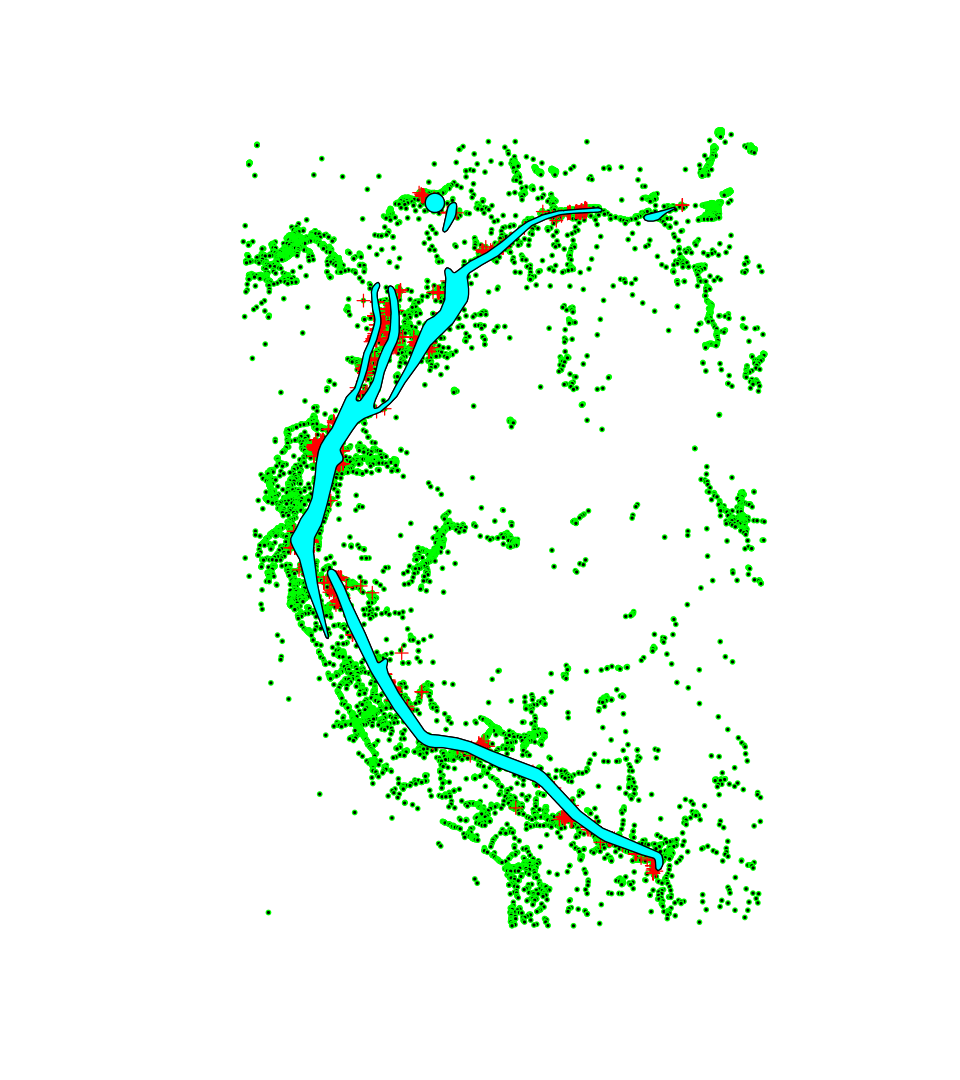

In [68]:
 # edit column names
 colnames(samplingp@data) <- c("observation")
 samplingp$presence=0
 plot(samplingp, col="green",pch=21,cex=.5)#absences
 plot(points, col="red",add=TRUE)#presences
 plot(birdrange, col="cyan",add=TRUE)#species range

In [69]:
head(samplingp)

,observation,presence
2518,1,0
2519,2,0
2520,1,0
2523,2,0
2525,1,0
2529,1,0


combine presence and non-presence point datasets

In [70]:
pdata <- rbind(points[,"presence"],samplingp[,"presence"])
pdata@data[,c("lon","lat")] <- coordinates(pdata)
table(pdata$presence)


    0     1 
17420  3438 

### Plot the environmental data layers

In [86]:
env <- stack(c(rCld,rCldIA,rElv,rVeg))
env

class      : RasterStack 
dimensions : 4200, 2760, 11592000, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -59, -21, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
names      : SA_meanannual_crop_msk, SA_intra_crop_msk, SA_elevation_mn_GMTED2010_mn_crop_msk, SA_tree_mn_percentage_GFC2013_crop_msk 
min values :                    859,                 0,                                   -72,                                      0 
max values :                  10000,              3790,                                  6460,                                  10000 


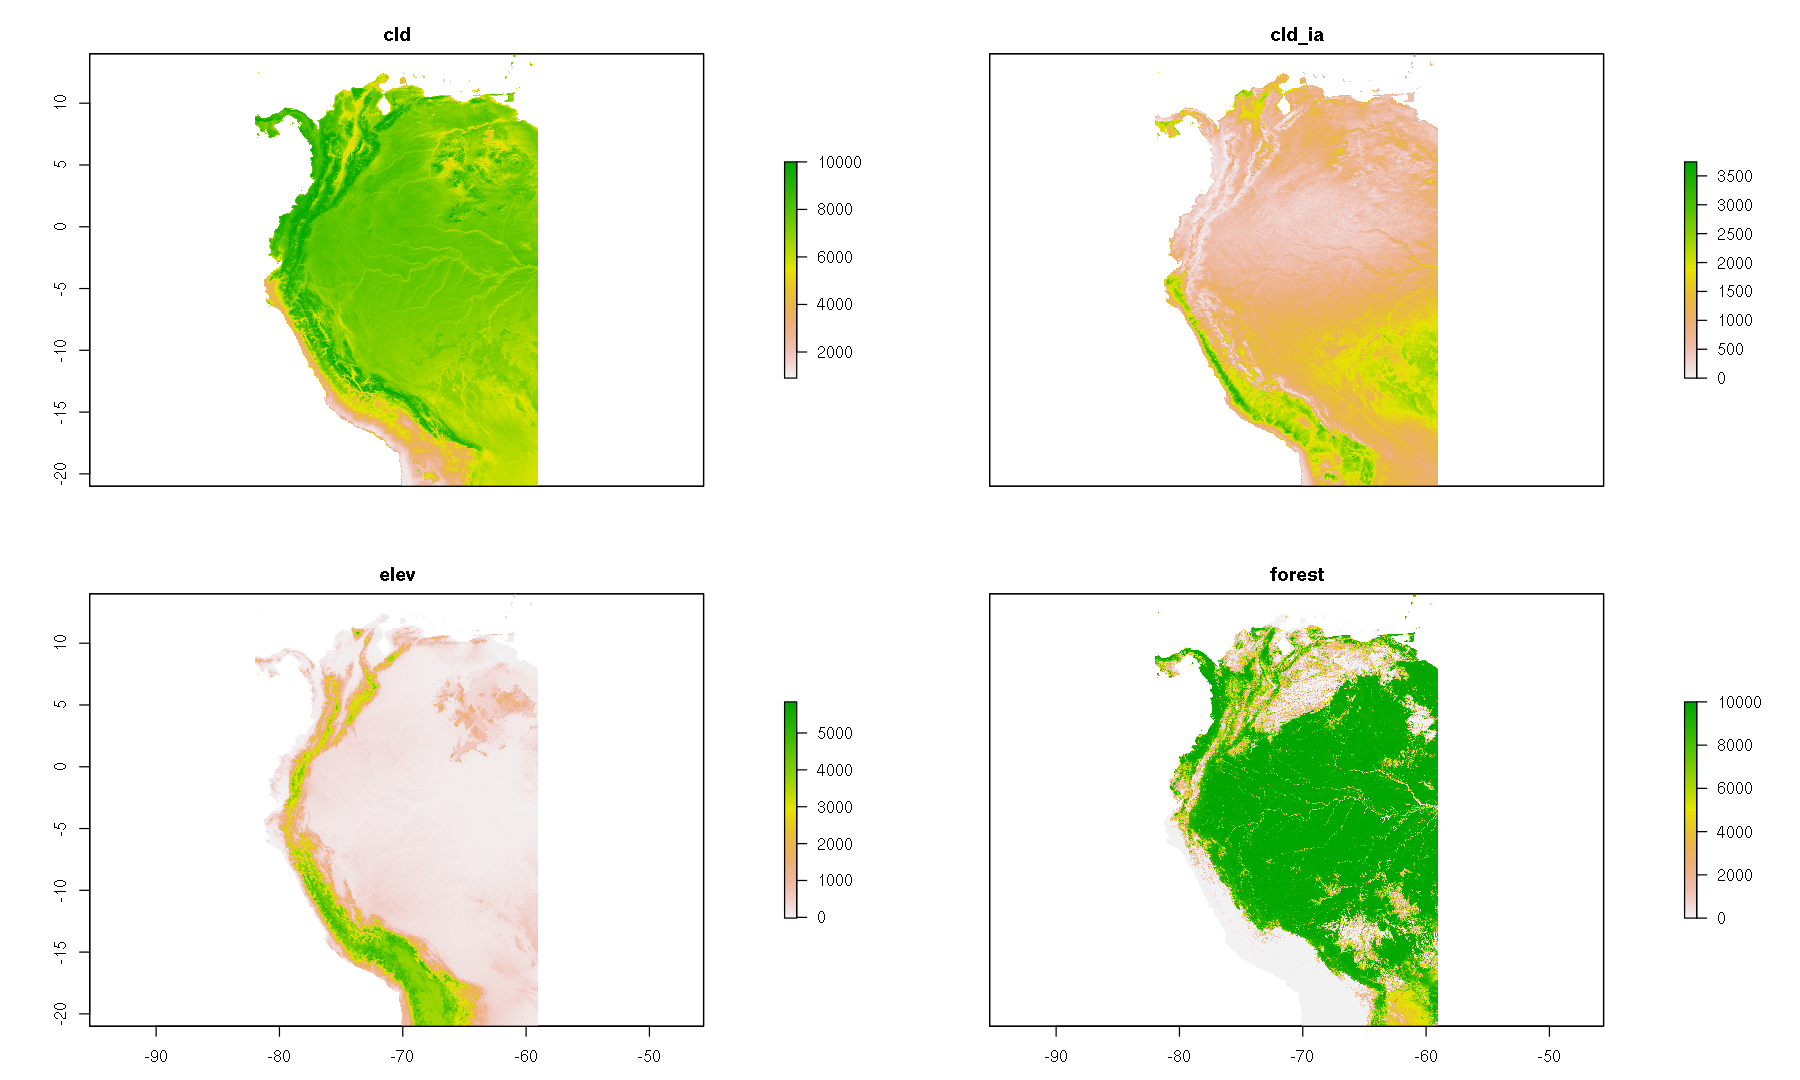

In [87]:
# rename layers for convenience
vars <- c("cld","cld_ia","elev","forest")

names(env) <- vars
 
# visual result 
options(repr.plot.width=15, repr.plot.height=9)
 # check out the plot
plot(env)

Scaling and centering the environmental variables to zero mean and variance of 1

In [88]:

senv <- scale(env[[vars]])
senv
# this operation is quite long. Would be possible to do in gdal? how?

class      : RasterBrick 
dimensions : 4200, 2760, 11592000, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -59, -21, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /tmp/Rtmpj2PfcG/raster/r_tmp_2021-04-09_221426_19629_20488.grd 
names      :        cld,     cld_ia,       elev,     forest 
min values : -4.5919892, -1.7513057, -0.6661006, -1.7261695 
max values :  2.1937157,  4.5331428,  5.0445753,  0.7798705 


Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warnin

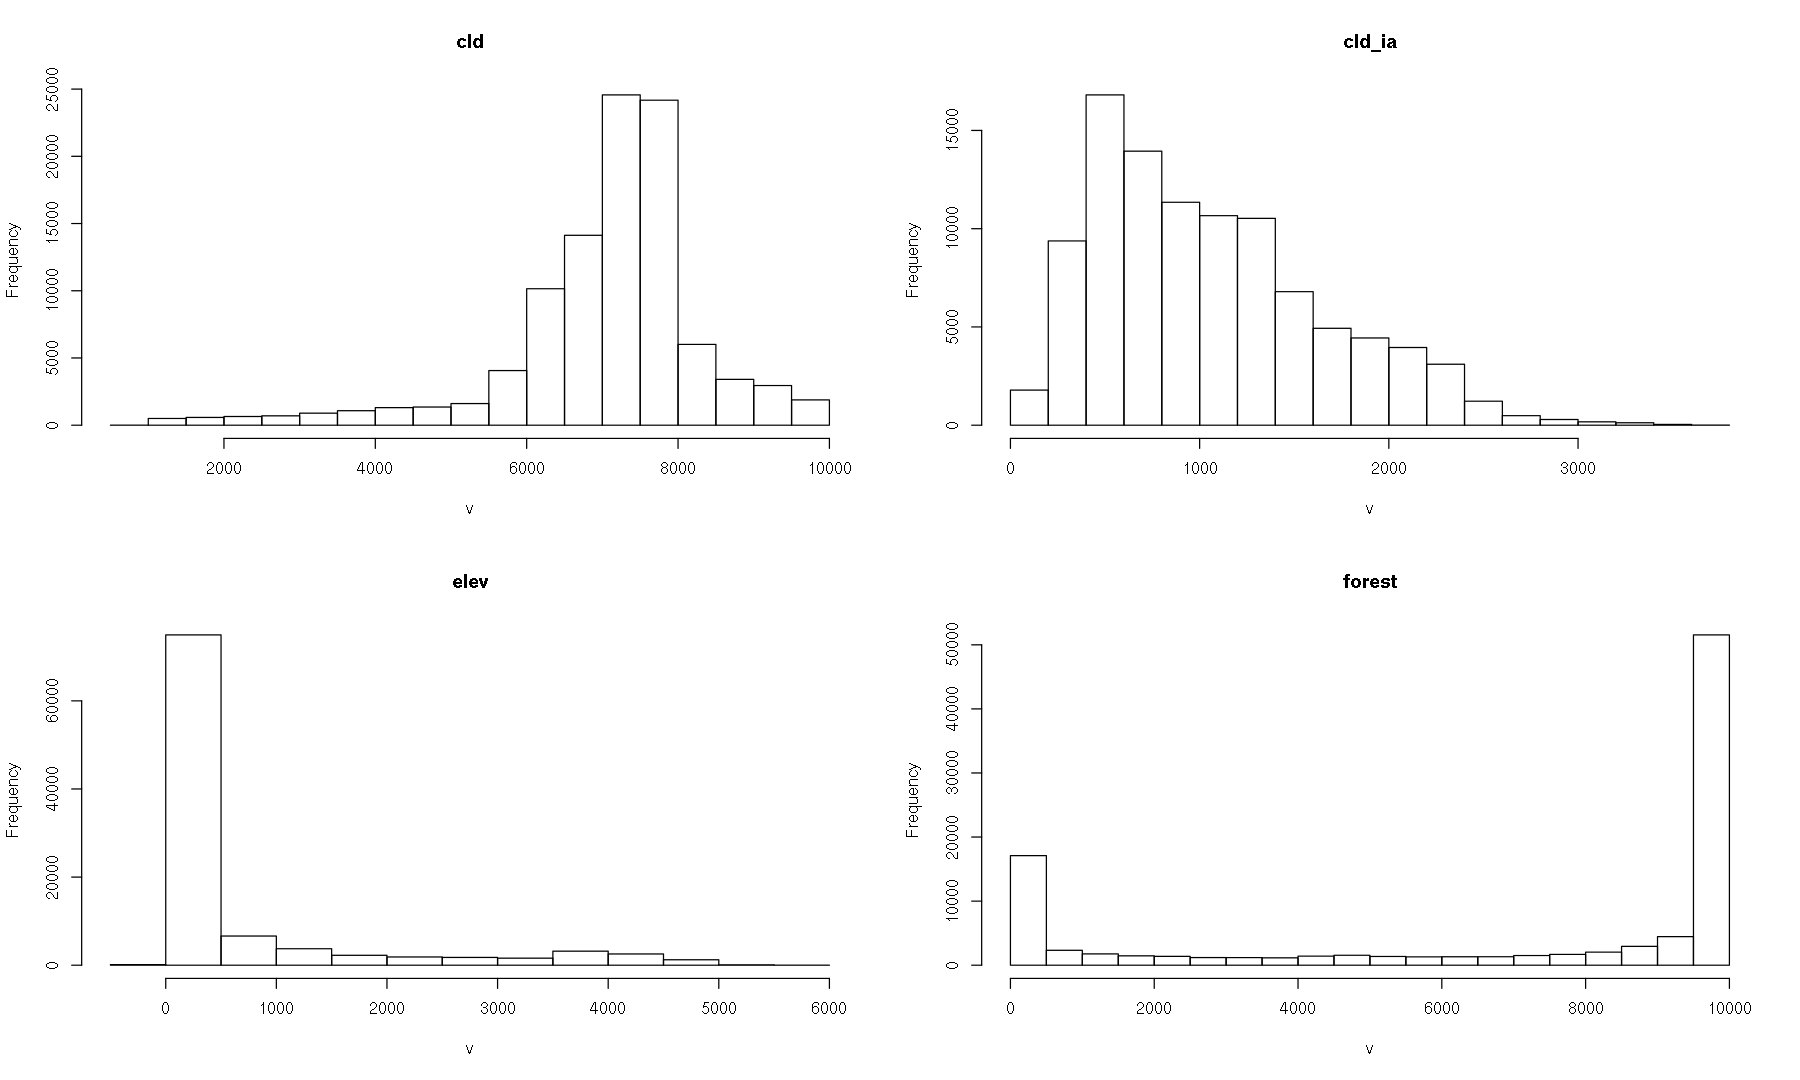

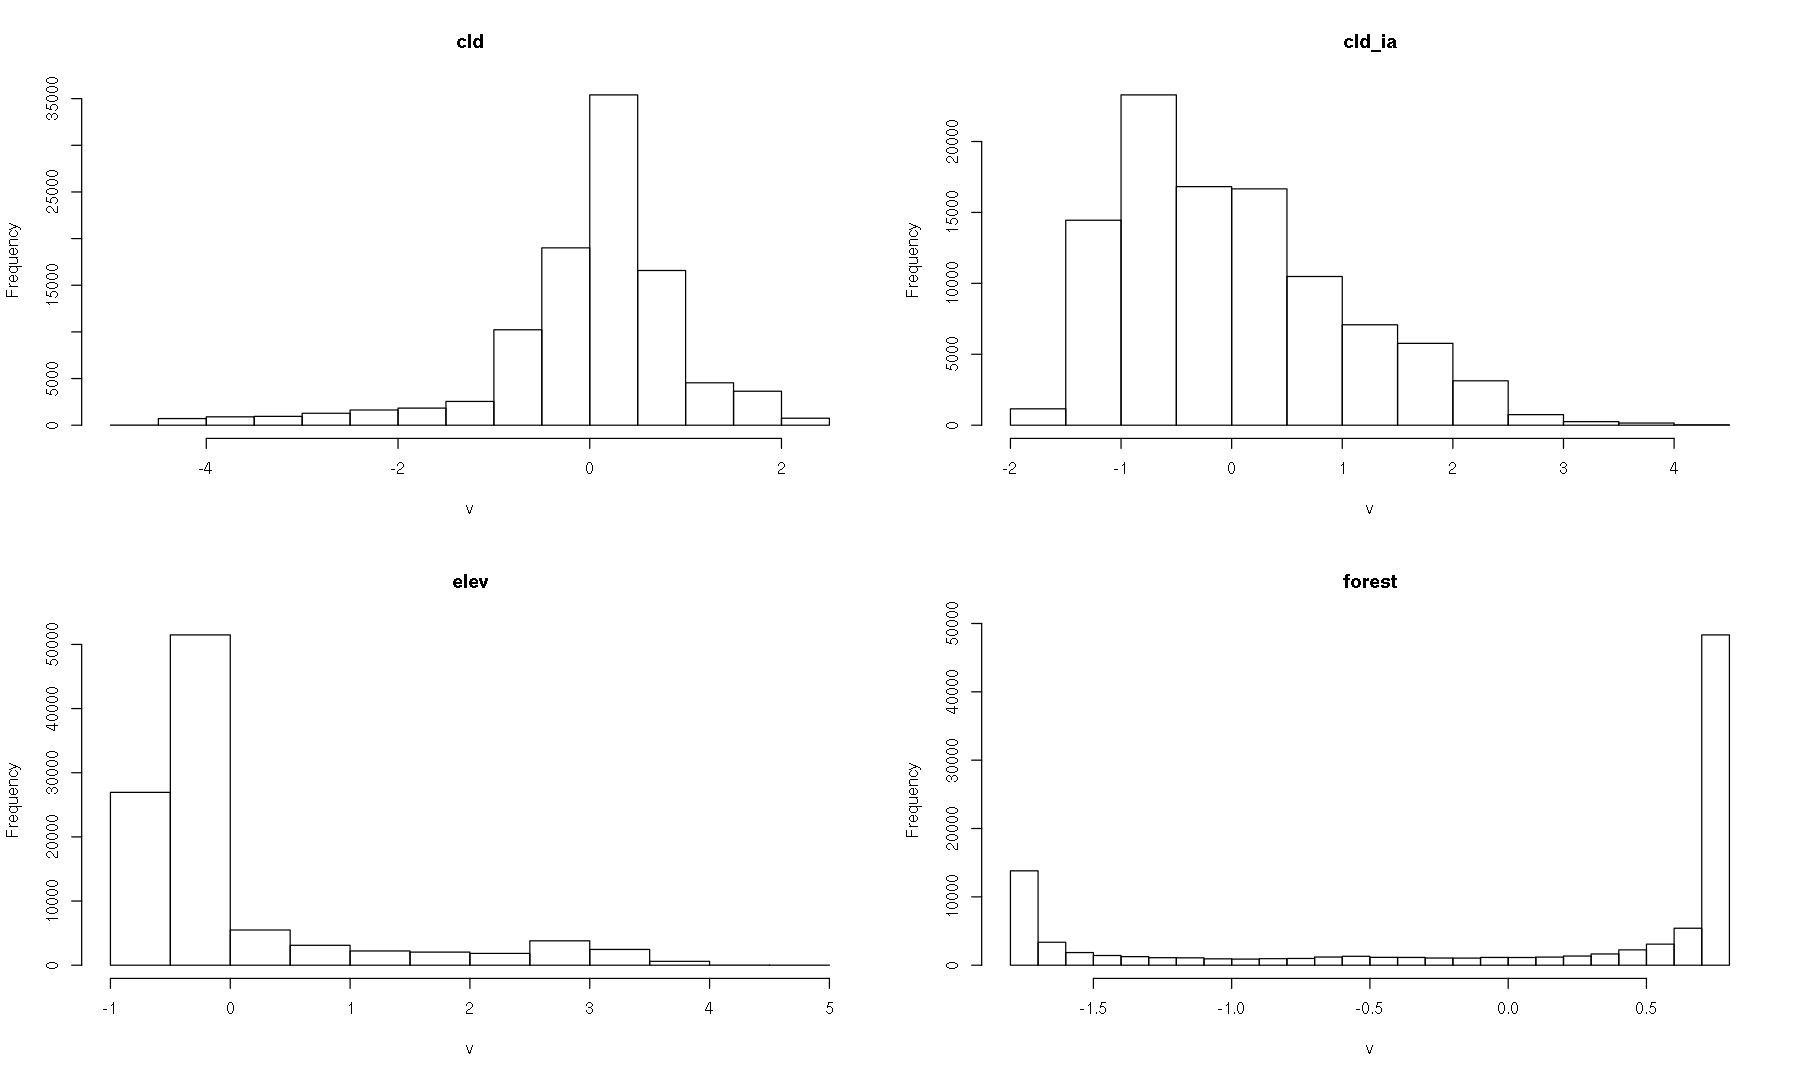

In [90]:
hist(env)
hist(senv)

Annotate the point records with the scaled environmental data

In [91]:
df.xact <- raster::extract(senv,pdata,sp=T) 

In [92]:
df.xact <- (df.xact[! is.na(df.xact$forest),])

### Correlation plots

In [93]:
## convert to 'long' format for easier plotting
df.xactl <- reshape::melt(df.xact@data,id.vars=c("lat","lon","presence"),variable.name="variable")

In [94]:
head(df.xactl)

lat,lon,presence,variable,value
3.98125,-76.18925,1,cld,1.3689791
3.93442,-76.18406,1,cld,1.7015461
4.60675,-74.30256,1,cld,2.0170395
4.60675,-74.30256,1,cld,2.0170395
4.74631,-76.10394,1,cld,0.8070298
4.74536,-76.13861,1,cld,1.1329159


In [95]:
tail(df.xactl)

,lat,lon,presence,variable,value
81811,-20.97083,-70.13750,0,forest,-1.726169
81812,-20.97083,-68.56250,0,forest,-1.726169
81813,-20.97916,-70.15417,0,forest,-1.726169
81814,-20.98749,-68.55417,0,forest,-1.726169
81815,-20.99583,-70.13750,0,forest,-1.726169
81816,-20.99583,-67.42917,0,forest,-1.726169


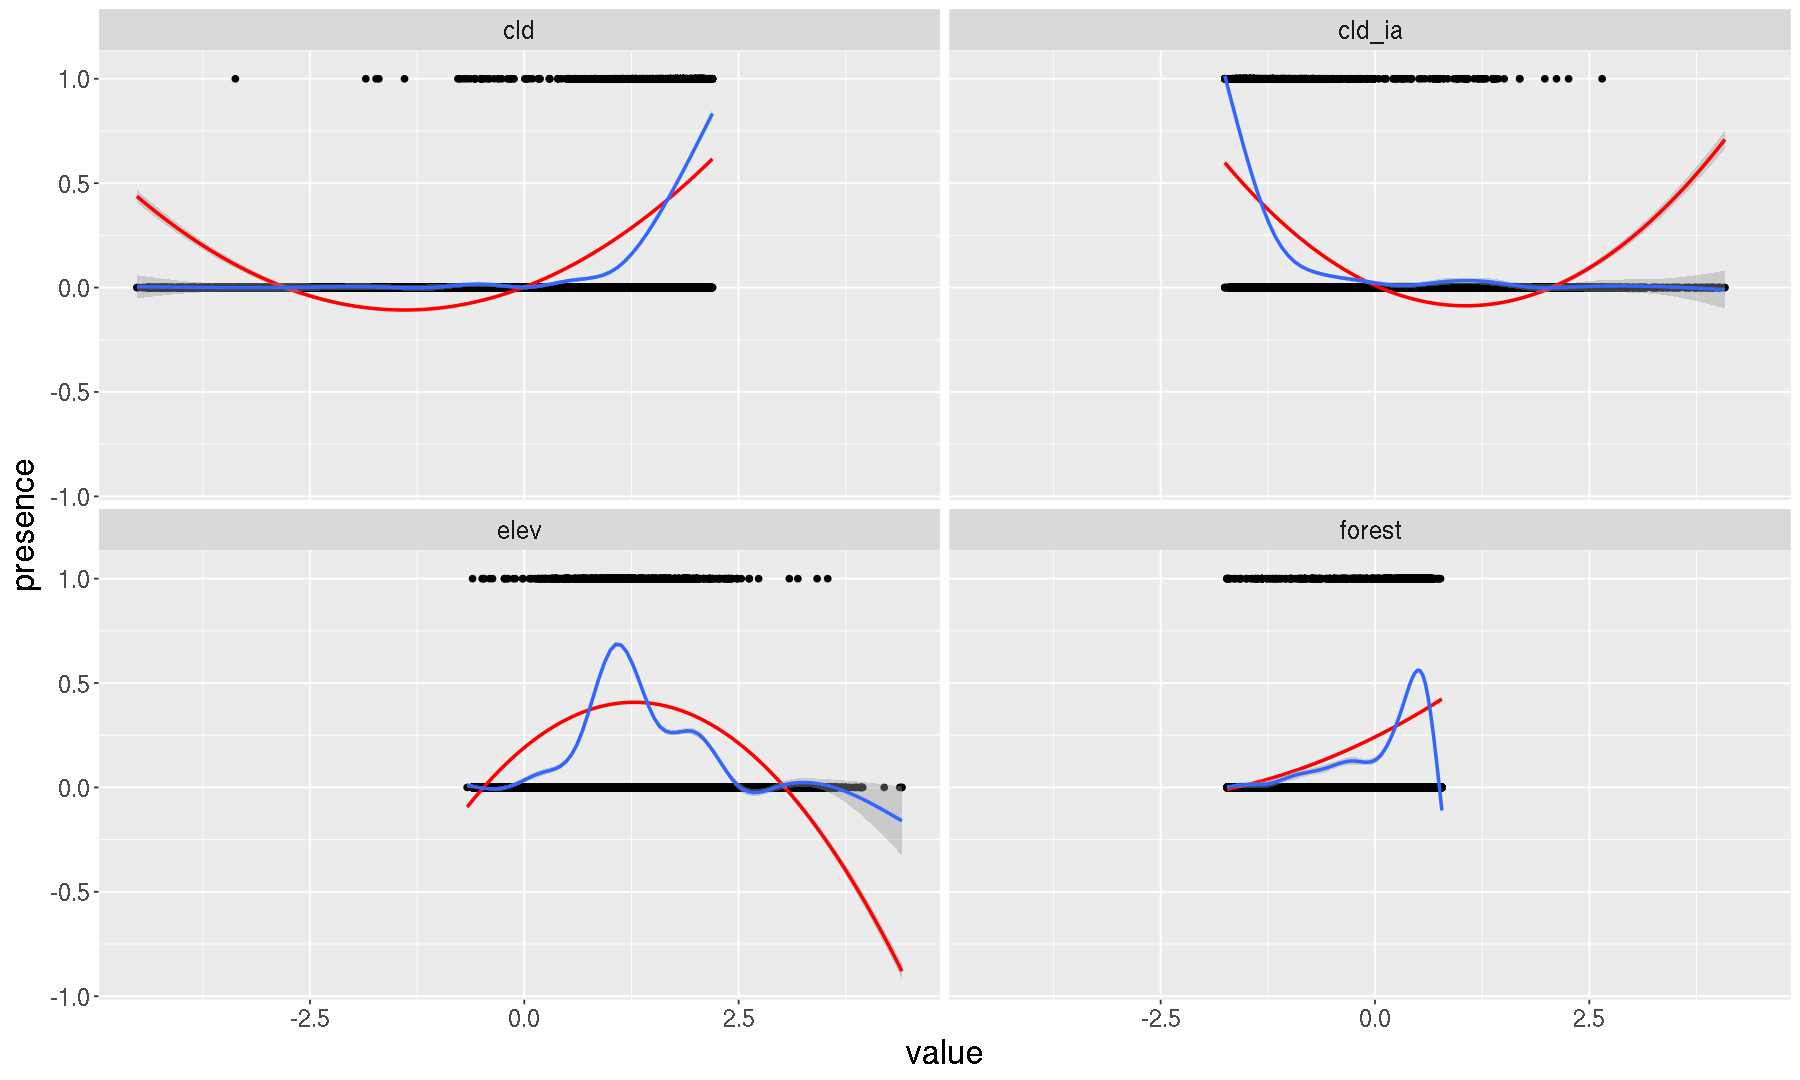

In [96]:
ggplot(df.xactl,aes(x=value,y=presence))+facet_wrap(~variable)+
  geom_point()+
  stat_smooth(method = "lm", formula = y ~ x + I(x^2), col="red")+
  geom_smooth(method="gam",formula=y ~ s(x, bs = "cs")) + 
  theme(text = element_text(size = 20))  

### Model Fitting


cross validation 


<img src='./images/cross_vld.gif' width="600">

In [97]:
df.xact <- as.data.frame(df.xact)

In [98]:
df.xact$grp <- kfold(df.xact,2)

In [99]:
head(df.xact)

presence,lon,lat,cld,cld_ia,elev,forest,lon.1,lat.1,grp
1,-76.18925,3.98125,1.3689791,-1.381535,0.4922958,-0.19272362,-76.18925,3.98125,2
1,-76.18406,3.93442,1.7015461,-1.391484,0.7895447,0.37163657,-76.18406,3.93442,1
1,-74.30256,4.60675,2.0170395,-1.610362,1.6471952,0.03181757,-74.30256,4.60675,2
1,-74.30256,4.60675,2.0170395,-1.610362,1.6471952,0.03181757,-74.30256,4.60675,1
1,-76.10394,4.74631,0.8070298,-1.101305,0.8874620,0.51397967,-76.10394,4.74631,1
1,-76.13861,4.74536,1.1329159,-1.245565,0.9215583,0.12403984,-76.13861,4.74536,2


In [100]:
mdl.glm <- glm(presence~cld+cld_ia*I(cld_ia^2)+elev*I(elev^2)+forest, family=binomial(link=logit), data=subset(df.xact,grp==1))

In [101]:
summary(mdl.glm)


Call:
glm(formula = presence ~ cld + cld_ia * I(cld_ia^2) + elev * 
    I(elev^2) + forest, family = binomial(link = logit), data = subset(df.xact, 
    grp == 1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1201  -0.1678  -0.0180  -0.0023   5.1070  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -5.40732    0.23181 -23.327  < 2e-16 ***
cld                 1.19661    0.14515   8.244  < 2e-16 ***
cld_ia              0.71223    0.14739   4.832 1.35e-06 ***
I(cld_ia^2)         0.31000    0.05714   5.425 5.79e-08 ***
elev                6.11978    0.55508  11.025  < 2e-16 ***
I(elev^2)          -2.74122    0.49940  -5.489 4.04e-08 ***
forest              1.35894    0.08211  16.551  < 2e-16 ***
cld_ia:I(cld_ia^2) -0.14284    0.04419  -3.233  0.00123 ** 
elev:I(elev^2)      0.21677    0.13560   1.599  0.10990    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial fam

### Prediction

Calculate estimates of p(occurrence) for each cell.
We can use the predict function in the raster package to make the predictions across the full raster grid and save the output.

In [102]:
pred.glm1 <- predict(mdl.glm,df.xact[which(df.xact$grp==1),vars],type="response")
pred.glm2 <- predict(mdl.glm,df.xact[which(df.xact$grp==2),vars],type="response")

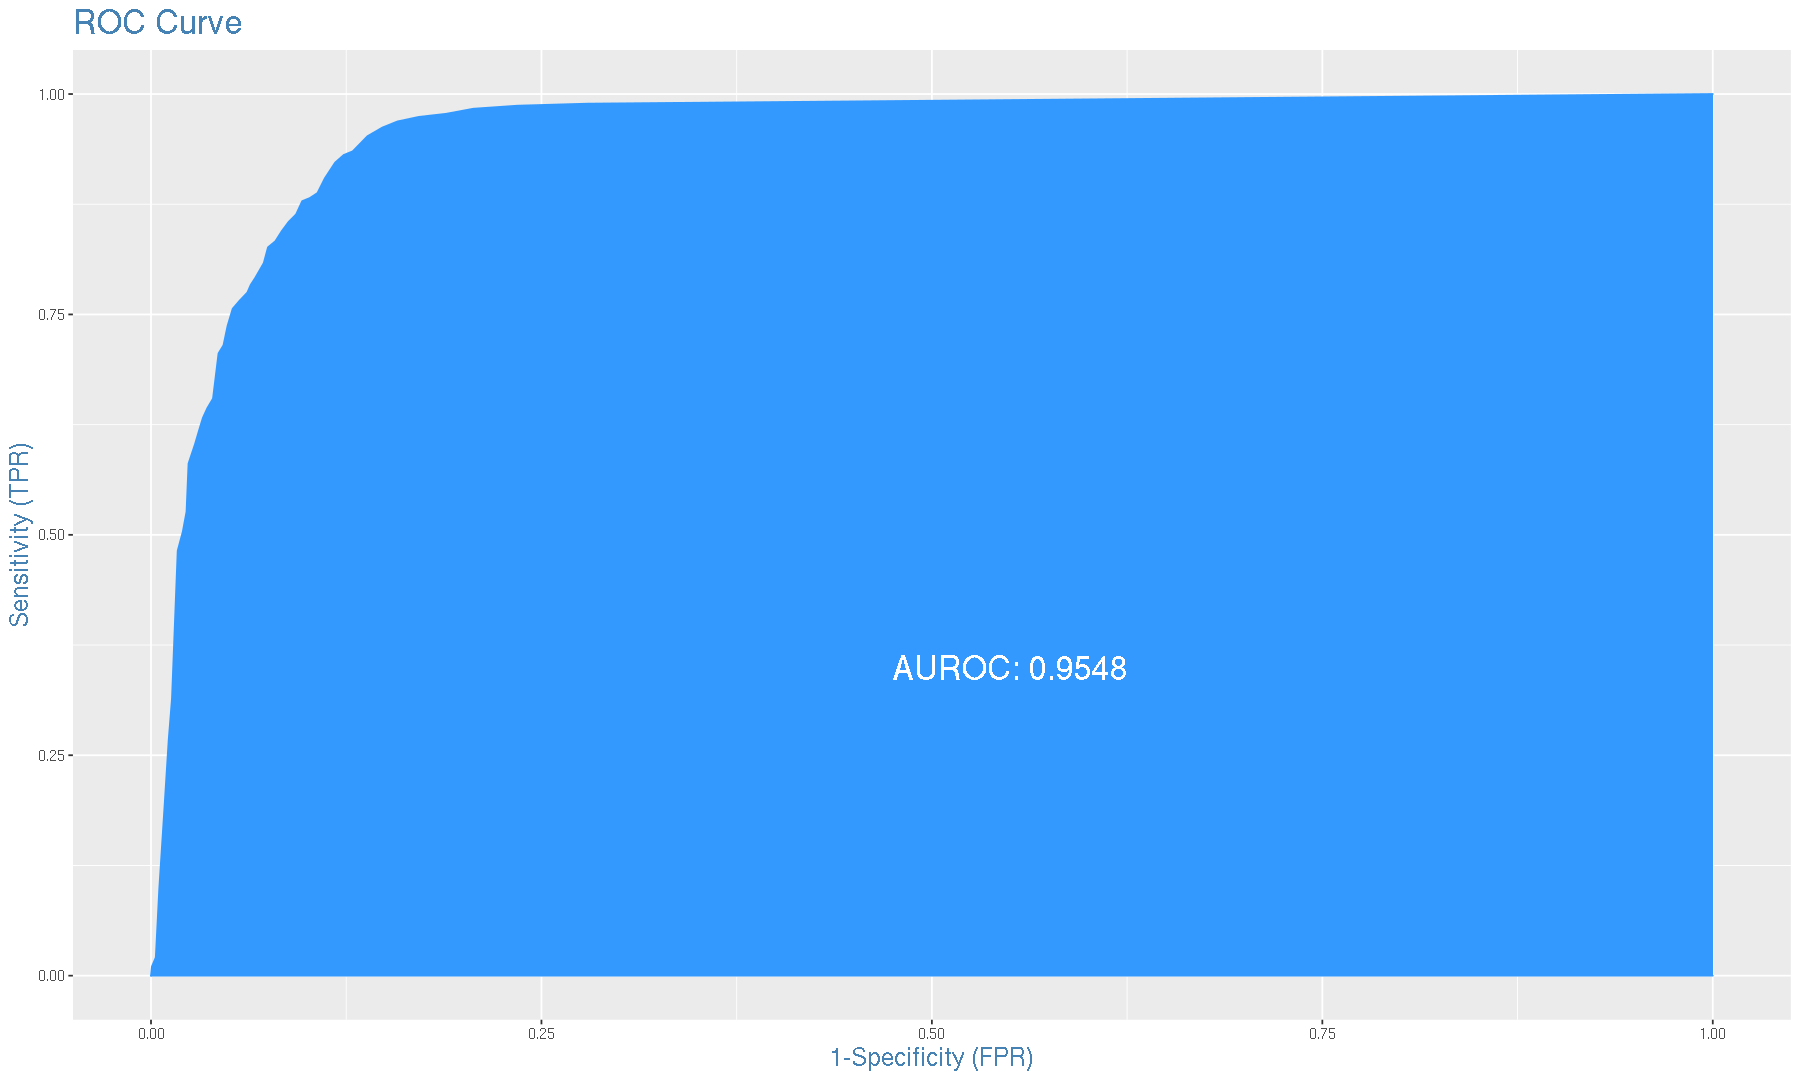

In [103]:
plotROC(df.xact[which(df.xact$grp==1),"presence"],pred.glm1)

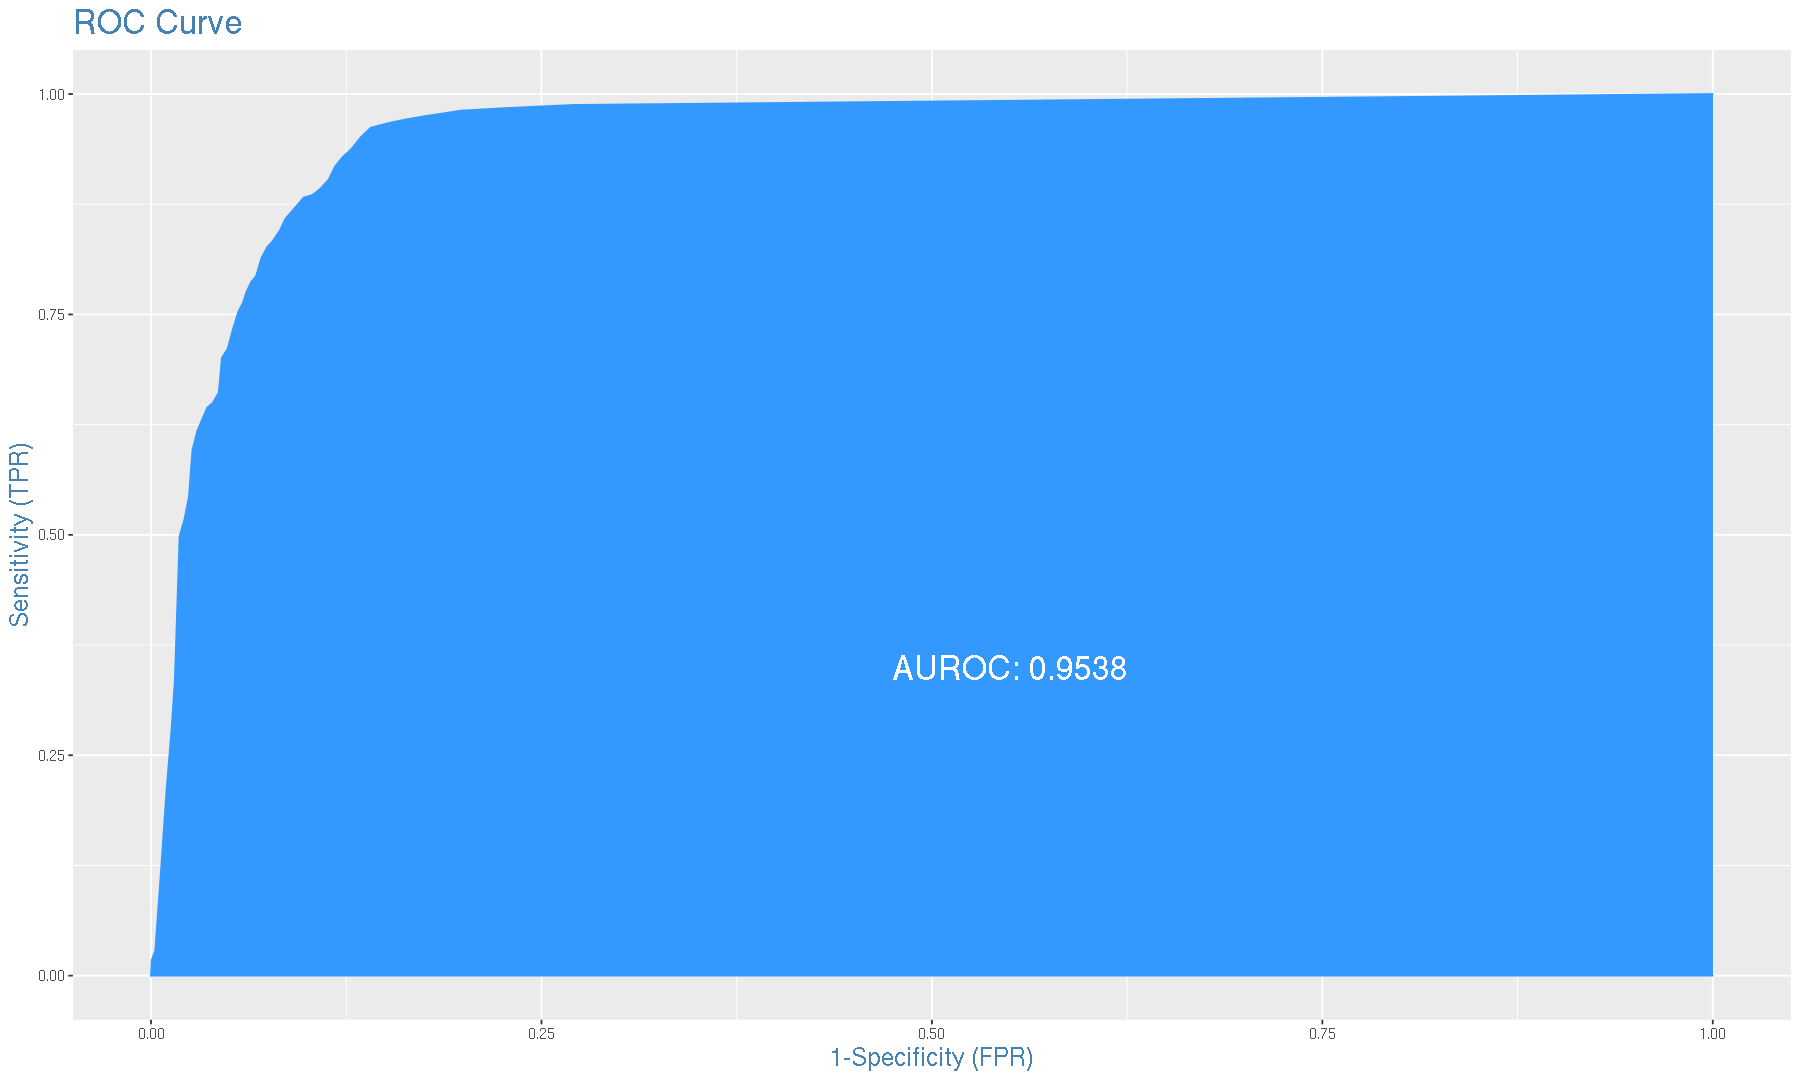

In [104]:
plotROC(df.xact[which(df.xact$grp==2),"presence"],pred.glm2)

### Out mapping

In [105]:
p1 <- raster::predict(senv,mdl.glm,type="response")

Plot the results as a map:

Regions defined for each Polygons


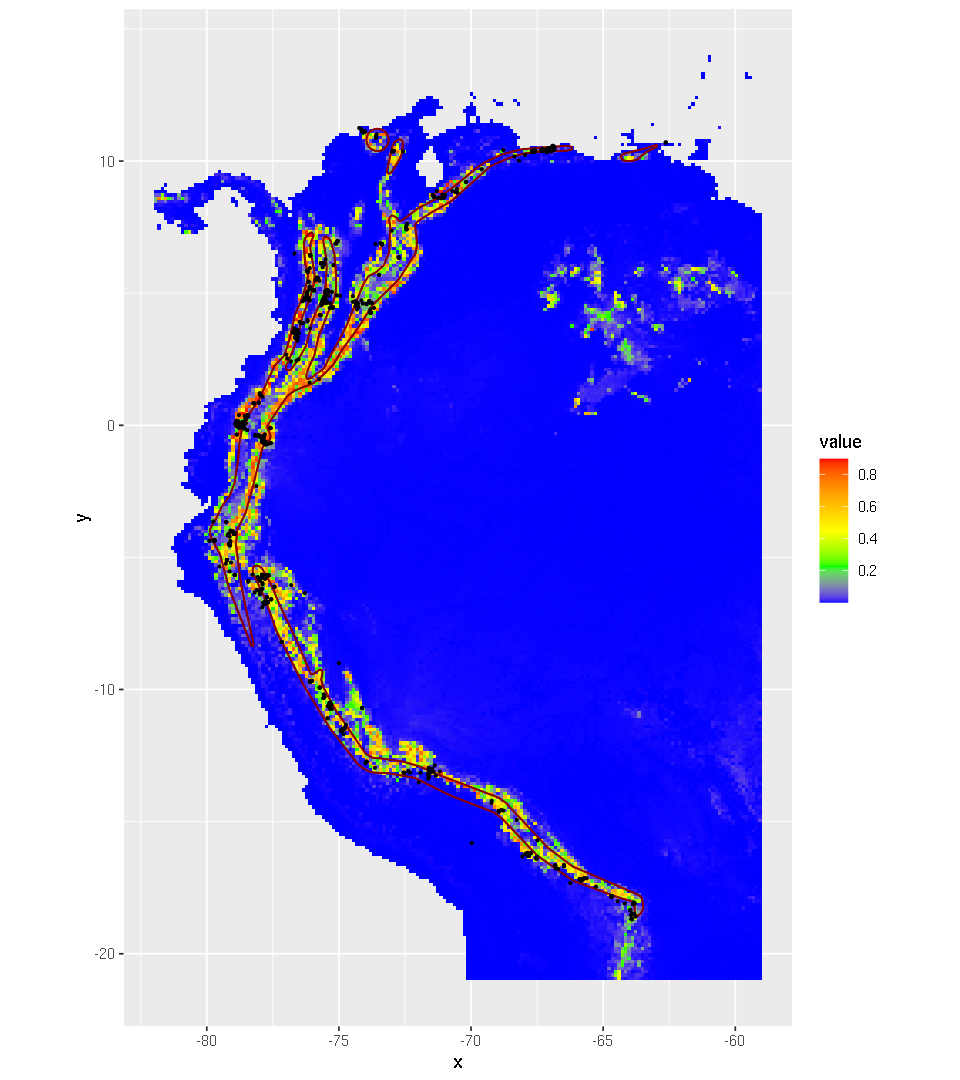

In [107]:
options(repr.plot.width=8, repr.plot.height=9)
gplot(p1)+geom_tile(aes(fill=value))+
  scale_fill_gradientn(
    colours=c("blue","green","yellow","orange","red"),
    na.value = "transparent")+
  geom_polygon(aes(x=long,y=lat,group=group),
               data=fortify(birdrange),fill="transparent",col="darkred")+
  geom_point(aes(x = lon, y = lat), data = subset(df.xact,presence==1),col="black",size=0.5)+
  coord_equal()

## References

- https://en.wikipedia.org/wiki/Cross-validation